# **TABLES OF CONTENTS**

## 1. Data Cleaning 
## 2. Data Exploration
## 3. Data Splitting
## 4. Regression Models
## 5. Classification Models
## 6. Conformal Prediction

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem import PandasTools
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.DataStructs import ConvertToNumpyArray
from molvs import Standardizer

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import root_mean_squared_error, r2_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE  
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMRegressor, LGBMClassifier
import xgboost as xgb
from skopt import gp_minimize
from skopt.space import Real, Integer
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sys.path.append('../plot_utils/python/src') # Correct the path to src of plot_utils on your device
from pharmbio.cp import metrics, plotting
from pharmbio.cpsign import *
from nonconformist.cp import IcpClassifier, TcpClassifier,IcpRegressor
from nonconformist.nc import NcFactory

sys.path.append('..')
from utils.data_processing import smiles_standardizer, smiles_df_to_morgan_fps, remove_correlated_features, calc_descriptors
from utils.cross_validation_pipeline import cross_validation_regressor, cross_validation_classifier
from utils.hyperparameter_tunning_pipeline import *

fig_size = (14,7)
plotting.update_plot_settings(context='talk', font_scale=1.2)

# **1. Data Cleaning**

In [3]:
df = pd.read_csv('../data/dataset.csv')
df.columns = ['smiles','Ki']

## Drop duplications

To prevent data leakage, we investigated the duplication of compounds, using different consideration: duplication in terms of SMILES string, isotope, tautomer, largest fragment, charge, and stereochemistry. The result showed that the duplications mostly come from different SMILES strings of the same compounds.

In [ ]:
tqdm.pandas()
duplicated_result = {'Factors': ['initial'],
                     'Remain Compounds': [df.shape[0]]}

df['cannonical_smiles'] = df['smiles'].progress_apply(lambda smi: smiles_standardizer(smi))
duplicated_result['Factors'].append('Cannonical SMILES')
duplicated_result['Remain Compounds'].append(df.drop_duplicates(['cannonical_smiles']).shape[0])

steps = ['isotope','tautomer','charge','fragment','stereo']
flags = {k: False for k in steps}
for i, step in enumerate(steps):
    for j in range(i + 1):
        flags[steps[j]] = True

    col_name = f'{"+".join([k for k in steps[:i+1]])}'
    df[col_name] = df['smiles'].progress_apply(lambda smi: smiles_standardizer(
        smi,
        fragment=flags['fragment'],
        isotope=flags['isotope'],
        charge=flags['charge'],
        stereo=flags['stereo'],
        tautomer=flags['tautomer']
    ))

    duplicated_result['Factors'].append(col_name)
    duplicated_result['Remain Compounds'].append(df.drop_duplicates([col_name]).shape[0])

duplicated_result = pd.DataFrame(duplicated_result)

100%|██████████| 7562/7562 [01:14<00:00, 101.41it/s]


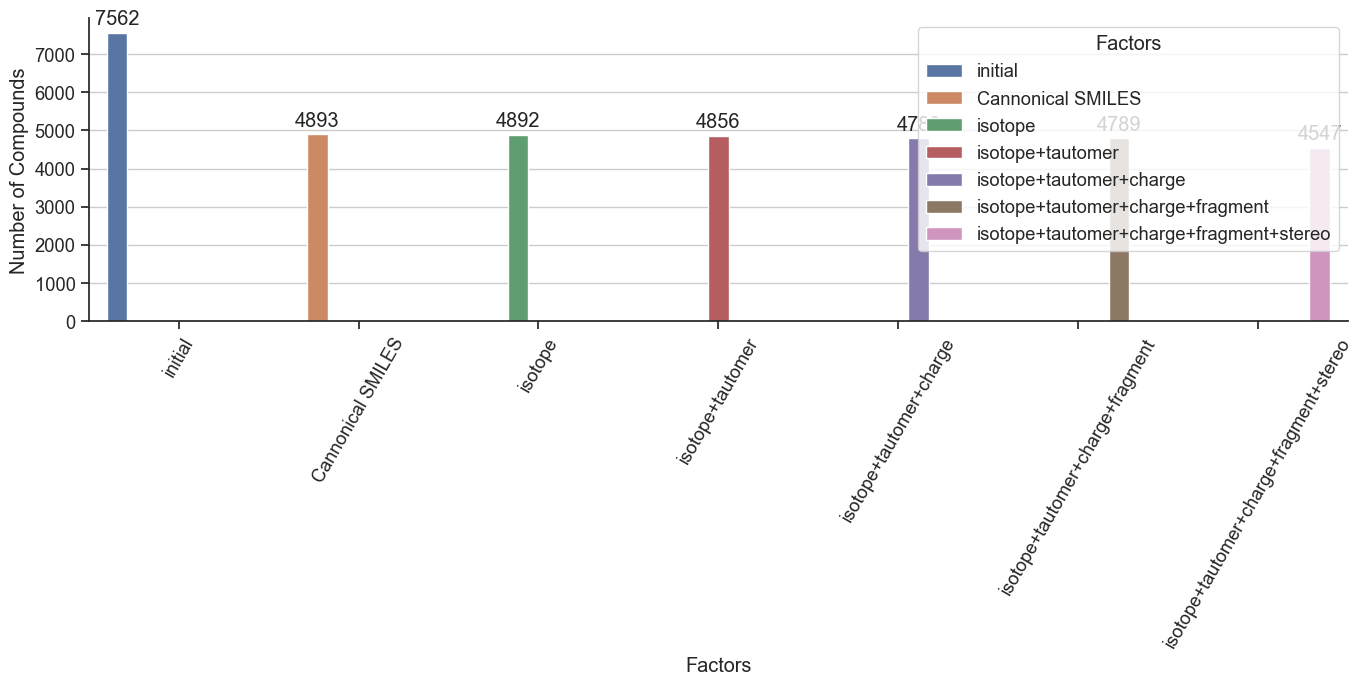

In [ ]:
plt.figure(figsize=fig_size)
plt.grid()
ax = sns.barplot(data=duplicated_result, x='Factors', y='Remain Compounds', hue='Factors')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)
plt.xticks(rotation=60)
plt.ylabel('Number of Compounds')
plt.tight_layout()
plt.show()

## Aggregate multiple records for one compound

The duplicated compounds are due to different SMILES strings and Ki values, which I assume come from different sources or testing times. Therefore, they are aggregated using the mean.

In [6]:
# Standardized smiles
df_total = df[['isotope+tautomer+charge+fragment+stereo','Ki']]
df_total.columns = ['smiles','Ki']
df_total['pKi'] = -np.log10(df_total['Ki'])+9
df_total = df_total.dropna()

# Aggregate pKi
df_total = df_total.groupby('smiles', as_index=False)['pKi'].mean()

/var/folders/xg/drggnx1n5cv7mnctplfkwlzh0000gn/T/ipykernel_19671/1119241208.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['pKi'] = -np.log10(df_total['Ki'])+9


# **2. Data Exploration**

## Outlier investigation

In [70]:
df_total = pd.read_csv('../data/dataset_clean.csv')

/Users/lod/miniconda3/envs/MLcode/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


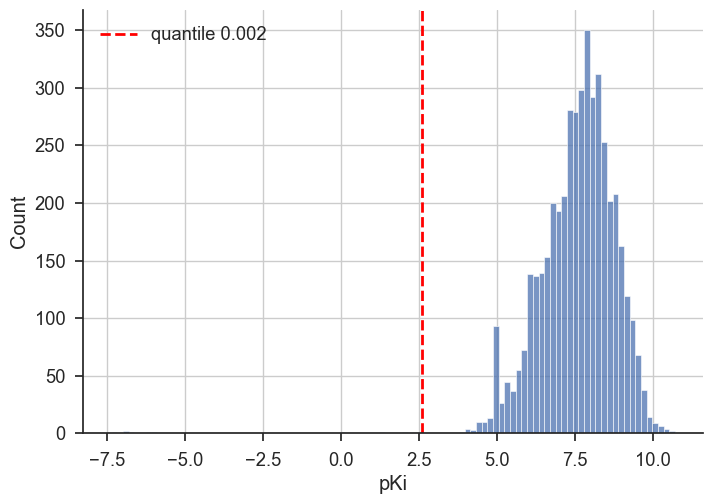

In [71]:
# Target value pKi
threshold = df_total['pKi'].quantile(0.002)

sns.histplot(data=df_total,x='pKi')
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'quantile 0.002')
plt.grid()
plt.legend()

In [72]:
# Filter out outliers
df_total = df_total[df_total['pKi']>threshold]
df_total = df_total.reset_index(drop=True)

## Inactive/Active Threshold selection

In [73]:
top_10_pKi = df_total.sort_values('pKi',ascending=False).iloc[0:round(df_total.shape[0]*0.1)].iloc[-1,1]
print(f'Active/Inactive pKi Threshold: {top_10_pKi}')
print(f'Active/Inactive Ki Threshold: {10**(-(top_10_pKi)+9)} nM')

df_total['class'] = (df_total['pKi'] >= top_10_pKi).astype(int)

Active/Inactive pKi Threshold: 8.960409376976187
Active/Inactive Ki Threshold: 1.0954451150103326 nM


/Users/lod/miniconda3/envs/MLcode/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lod/miniconda3/envs/MLcode/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/lod/miniconda3/envs/MLcode/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


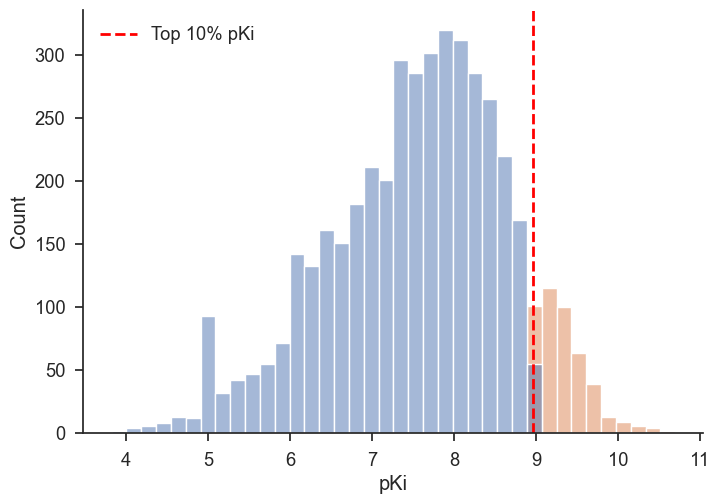

In [74]:
sns.histplot(data=df_total,x='pKi',hue='class')
plt.axvline(x=top_10_pKi, color='red', linestyle='--', linewidth=2, label=f'Top 10% pKi')
plt.legend()

## Generate descriptors

In [75]:
tqdm.pandas()
descriptor_list = [desc[0] for desc in Descriptors._descList]
descriptor_values = df_total['smiles'].progress_apply(calc_descriptors)
df_descriptors = pd.DataFrame(descriptor_values.tolist(), columns=descriptor_list)

100%|██████████| 4531/4531 [00:35<00:00, 128.52it/s]


In [76]:
# Drop descriptors that only have 1 value for all compounds
remove_descriptors = []
for col in df_descriptors.columns:
    num_values = len(df_descriptors[col].value_counts())
    if num_values == 1: 
        remove_descriptors.append(col)

df_descriptors = df_descriptors.drop(remove_descriptors,axis=1)

# Filter high correlated features
df_descriptors = remove_correlated_features(df_descriptors,0.7)

In [77]:
float_descriptors = df_descriptors.select_dtypes(include='float').to_numpy()
int_descriptors = df_descriptors.select_dtypes(include='int').to_numpy()

# Standardize descriptors
descriptor_scaler = StandardScaler()
scaled_float_descriptors = descriptor_scaler.fit_transform(float_descriptors)
scaled_descriptors = np.concatenate([scaled_float_descriptors,int_descriptors],axis=1)

# Standardize target values
target_scaler = StandardScaler()
scaled_targets = target_scaler.fit_transform(df_total[['pKi']]).reshape(-1)

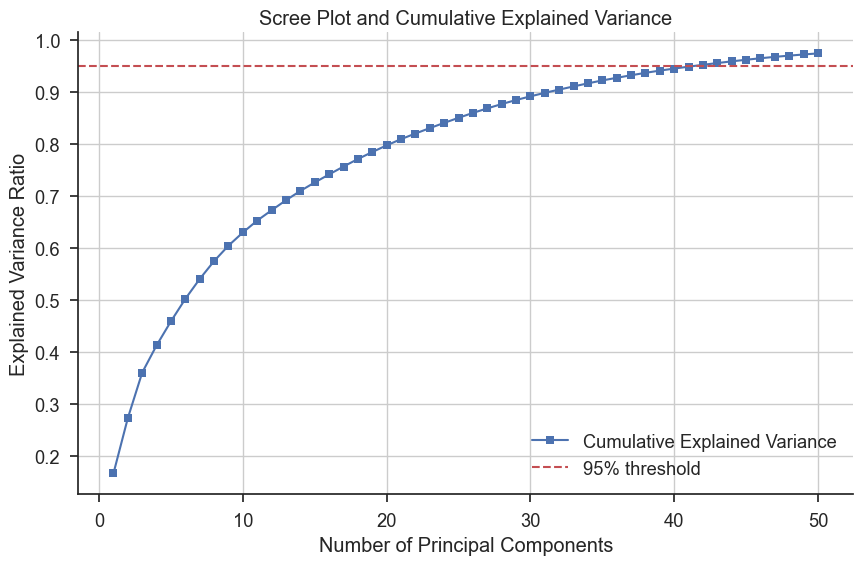

In [78]:
pca = PCA(n_components=50)
decomposed_descriptors = pca.fit_transform(scaled_descriptors)
explained_var = pca.explained_variance_ratio_
cumulative_var = explained_var.cumsum()

# Plot Cumulative Variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='s', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot and Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

## Generate fingerprint

In [80]:
morgan_fp = smiles_df_to_morgan_fps(df_total,smiles_column='smiles')

[11:16:03] DEPRECATION WARNING: please use MorganGenerator
[11:16:03] DEPRECATION WARNING: please use MorganGenerator
[11:16:03] DEPRECATION WARNING: please use MorganGenerator
[11:16:03] DEPRECATION WARNING: please use MorganGenerator
[11:16:03] DEPRECATION WARNING: please use MorganGenerator
[11:16:03] DEPRECATION WARNING: please use MorganGenerator
[11:16:03] DEPRECATION WARNING: please use MorganGenerator
[11:16:03] DEPRECATION WARNING: please use MorganGenerator
[11:16:03] DEPRECATION WARNING: please use MorganGenerator
[11:16:03] DEPRECATION WARNING: please use MorganGenerator
[11:16:03] DEPRECATION WARNING: please use MorganGenerator
[11:16:03] DEPRECATION WARNING: please use MorganGenerator
[11:16:03] DEPRECATION WARNING: please use MorganGenerator
[11:16:03] DEPRECATION WARNING: please use MorganGenerator
[11:16:03] DEPRECATION WARNING: please use MorganGenerator
[11:16:03] DEPRECATION WARNING: please use MorganGenerator
[11:16:03] DEPRECATION WARNING: please use MorganGenerat

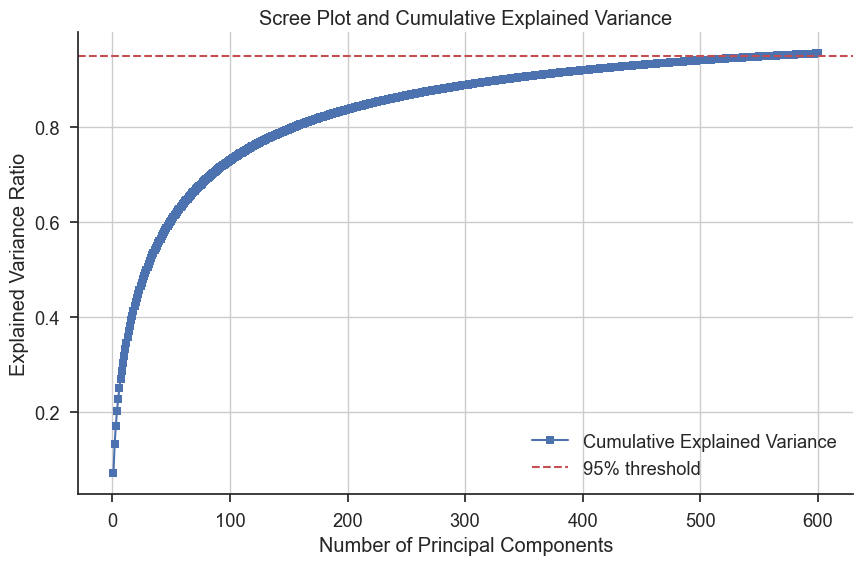

In [81]:
pca = PCA(n_components=600)
decomposed_fp = pca.fit_transform(morgan_fp)
explained_var = pca.explained_variance_ratio_
cumulative_var = explained_var.cumsum()

# Plot Cumulative Variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='s', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot and Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

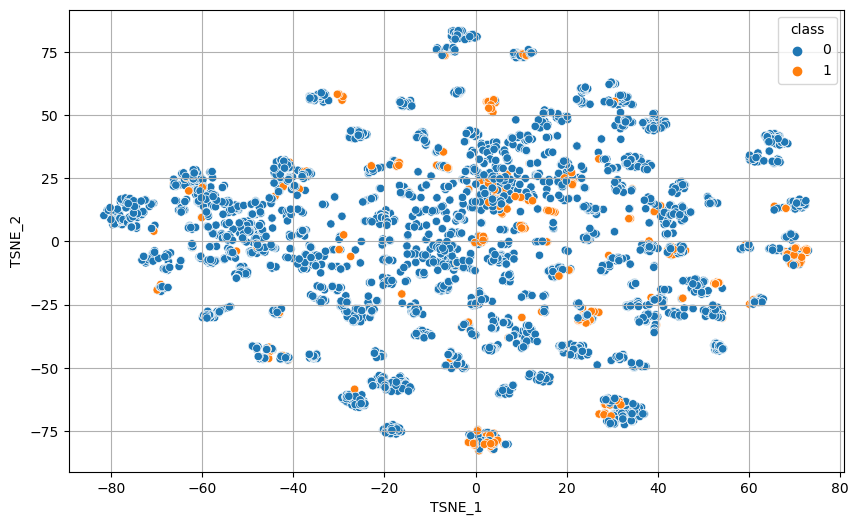

In [ ]:
# Plot chemical space
tsne = TSNE(n_components=2)
tsne_fp = tsne.fit_transform(decomposed_fp)

tsne_fp_df = pd.DataFrame(tsne_fp)
tsne_fp_df.columns = ['TSNE_1', 'TSNE_2']
tsne_fp_df['class'] = df_total['class']

plt.figure(figsize=(10,6))
sns.scatterplot(data=tsne_fp_df,x='TSNE_1',y='TSNE_2',hue='class')
plt.grid()

## **3. Data Splitting**

We have different training features: morgan_fp, descriptors, and their combinations. At this stage, we aim to split and obtain the indices. Each specific training feature will then be divided using these indices.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df_total, scaled_targets, random_state=2406, test_size=0.2)
X_prop_train, X_calibrate, y_prop_train, y_calibrate = train_test_split(X_train, y_train, random_state=2406, test_size=0.2)

prop_train_index = X_prop_train.index
calibrate_index = X_calibrate.index
test_index =  X_test.index

In [82]:
# Combine descriptors and fingerprint
desc_fp = np.concatenate([scaled_descriptors,morgan_fp],axis=1)
decomposed_desc_fp = np.concatenate([decomposed_descriptors,decomposed_fp],axis=1)

# **4. Regression model**

## Hyperparameter tunning

In [ ]:
X_prop_train = morgan_fp[prop_train_index]
X_calibrate = morgan_fp[calibrate_index]
X_test = morgan_fp[test_index]

In [ ]:
result = optimize_xgboost_regressor(X_prop_train,y_prop_train,X_test,y_test,n_calls=50)

## Model comparision

In [26]:
regressors_dict = {'svm_desc': SVR(C = 0.6044586122239554, epsilon = 0.004093569498064611, gamma=0.023135165274467875, kernel='rbf'),
               'rf_desc': RandomForestRegressor(n_estimators=283,max_depth=15,min_samples_split=18,min_samples_leaf=4,max_features=0.5174699678810584,random_state=42,n_jobs=-1),
               'xgb_desc':xgb.XGBRegressor(n_estimators=300, max_depth=5, learning_rate = 0.0912292793840759, subsample = 1, colsample_bytree = 0.6227487023127756, reg_alpha=9.875923935948821, reg_lambda = 6.743523919823707, random_state=42, n_jobs=-1),
               'lgbm_desc': LGBMRegressor(n_estimators=300,max_depth=12,num_leaves=100,min_child_samples=100,learning_rate=0.032086954139500516,subsample=1,colsample_bytree=1,random_state=42,n_jobs=-1),
               'svm_fp': SVR(C=0.8222256548114378, epsilon = 0.005863433239231559, gamma =0.04653680467962141,kernel= 'rbf' ),
               'rf_fp': RandomForestRegressor(n_estimators=300,max_depth=20,min_samples_split=2,min_samples_leaf=4,max_features=0.26806290922292203,random_state=42,n_jobs=-1),
               'xgb_fp': xgb.XGBRegressor(n_estimators=300, max_depth=10, learning_rate = 0.09076406152654637, subsample = 0.6, colsample_bytree = 0.6, reg_alpha=8.940654347507643, reg_lambda = 10, random_state=42, n_jobs=-1),
               'lgbm_fp': LGBMRegressor(n_estimators=220,max_depth=9,num_leaves=55,min_child_samples=78,learning_rate=0.11525903652574118,subsample=0.7718434357132059,colsample_bytree=0.7923096070537669,random_state=42,n_jobs=-1),
               'svm_desc_fp': SVR(C=13.760929223892703,epsilon=0.08670994821545572,gamma=0.0028317098442873453,kernel='rbf'),
               'rf_desc_fp': RandomForestRegressor(n_estimators=300,max_depth=17,min_samples_split=20,min_samples_leaf=3,max_features=0.2538445208798436,random_state=42,n_jobs=-1),
               'xgb_desc_fp': xgb.XGBRegressor(n_estimators=87, max_depth=5, learning_rate = 0.12208180452649998, subsample = 0.961039390211762, colsample_bytree = 0.7799799959644911, reg_alpha=6.130634578841326, reg_lambda = 9.023485831739844, random_state=42, n_jobs=-1),
               'lgbm_desc_fp': LGBMRegressor(n_estimators=285,max_depth=7,num_leaves=50,min_child_samples=20,learning_rate=0.02834697682869342,subsample=1,colsample_bytree=0.6,random_state=42,n_jobs=-1),
               'baseline': RandomForestRegressor()}

In [ ]:
CV_train_result = {}
CV_val_result = {}
CV_test_result = {}

for key in regressors_dict.keys():
    if key == 'svm_desc':
        X_prop_train = decomposed_descriptors[prop_train_index]
        X_calibrate = decomposed_descriptors[calibrate_index]
        X_test = decomposed_descriptors[test_index]

    elif key in ['rf_desc','xgb_desc','lgbm_desc']:
        X_prop_train = scaled_descriptors[prop_train_index]
        X_calibrate = scaled_descriptors[calibrate_index]
        X_test = scaled_descriptors[test_index]

    elif key == 'svm_fp':
        X_prop_train = decomposed_fp[prop_train_index]
        X_calibrate = decomposed_fp[calibrate_index]
        X_test = decomposed_fp[test_index]

    elif key in ['rf_fp','xgb_fp','lgbm_fp','baseline']:
        X_prop_train = morgan_fp[prop_train_index]
        X_calibrate = morgan_fp[calibrate_index]
        X_test = morgan_fp[test_index]
  
    elif key == 'svm_desc_fp':
        X_prop_train = decomposed_desc_fp[prop_train_index]
        X_calibrate = decomposed_desc_fp[calibrate_index]
        X_test = decomposed_desc_fp[test_index]
    
    elif key in ['rf_desc_fp','xgb_desc_fp','lgbm_desc_fp']:
        X_prop_train = desc_fp[prop_train_index]
        X_calibrate = desc_fp[calibrate_index]
        X_test = desc_fp[test_index]

    print(f'Model {key}')
    model = regressors_dict.get(key)
    train_scores, val_scores, test_score = cross_validation_regressor(model, X_prop_train, y_prop_train, X_test, y_test)
    CV_train_result[key] = train_scores
    CV_val_result[key] = val_scores
    CV_test_result[key] = test_score

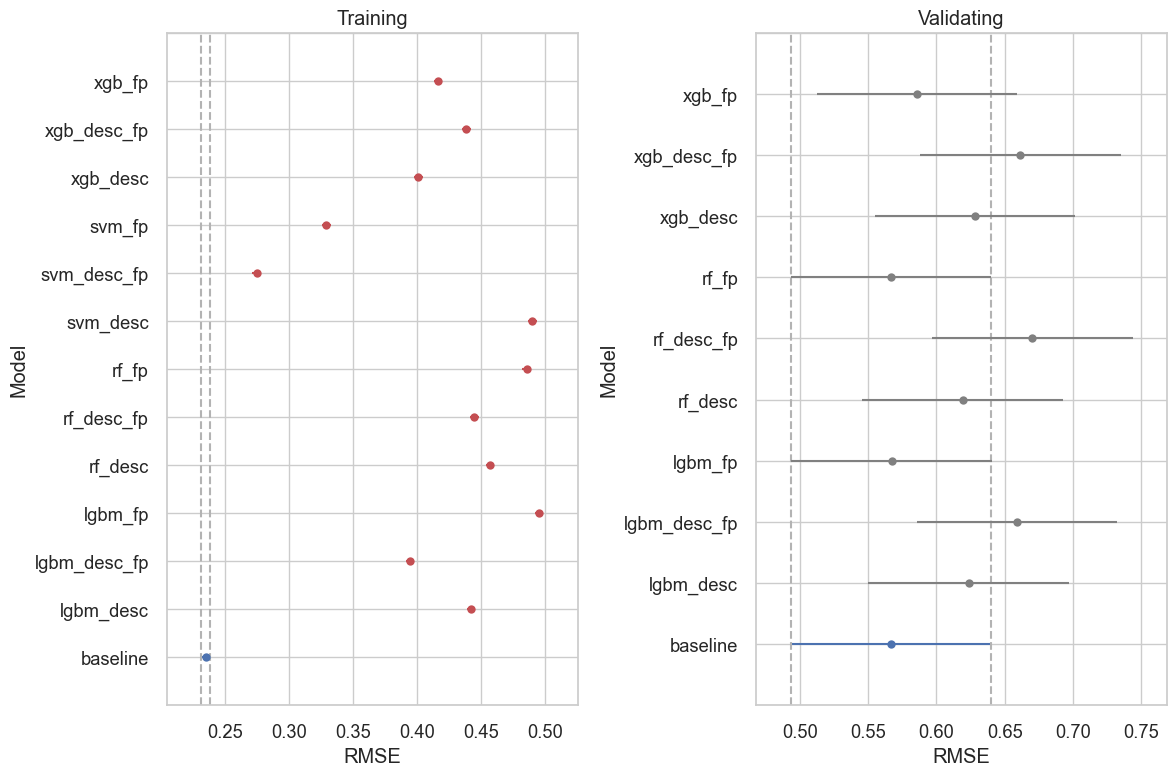

In [ ]:
CV_train_df = pd.DataFrame(CV_train_result)
CV_val_df = pd.DataFrame(CV_val_result)
df_train_melt = CV_train_df.melt(var_name='Model',value_name='RMSE')
df_val_melt = CV_val_df.melt(var_name='Model',value_name='RMSE')

# Run tukeyhsd test
tukey_val = pairwise_tukeyhsd(endog=df_val_melt['RMSE'], groups=df_val_melt["Model"], alpha=0.05)
tukey_train = pairwise_tukeyhsd(endog=df_train_melt['RMSE'], groups=df_train_melt["Model"], alpha=0.05)

# Plot results with CI
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 20))
tukey_train.plot_simultaneous('baseline', figsize=(12, 8), xlabel='RMSE', ylabel='Model', ax=axes[0])
tukey_val.plot_simultaneous('baseline', figsize=(12, 8), xlabel='RMSE', ylabel='Model', ax=axes[1])
for ax, title in zip(axes,['Training','Validating','Testing']):
    ax.grid(True)
    ax.set_title(title)
plt.tight_layout()
plt.show()

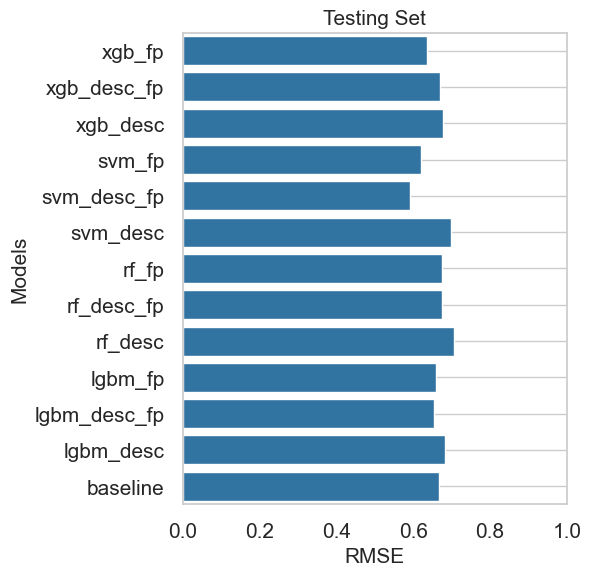

In [ ]:
# Plot test set result
df = pd.DataFrame(list(CV_test_result.items()), columns=['Model', 'Performance'])
df = df.sort_values('Model', ascending=False)

plt.figure(figsize=(6,6))
sns.barplot(y='Model', x='Performance', data=df, color='#1f77b4')
plt.ylabel('Models',fontsize=15)
plt.xlabel('RMSE',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Testing Set',fontsize=15)
plt.tight_layout()
plt.grid()
plt.xlim(0,1)
plt.show()

## Generalizability Analysis

In [ ]:
# Aggregate data
df_train_val_melt = df_train_melt.merge(df_val_melt,on='Model',suffixes=['_train','_val'])
df_train_val_melt['RMSE_Gap'] = np.abs(df_train_val_melt['RMSE_train']- df_train_val_melt['RMSE_val'])
pivot_train_val_melt = pd.pivot_table(df_train_val_melt,index='Model',aggfunc='mean').reset_index()
pivot_train_val_melt['Distance'] = np.sqrt(np.array(pivot_train_val_melt['RMSE_val'])**2+np.array(pivot_train_val_melt['RMSE_Gap'])**2)

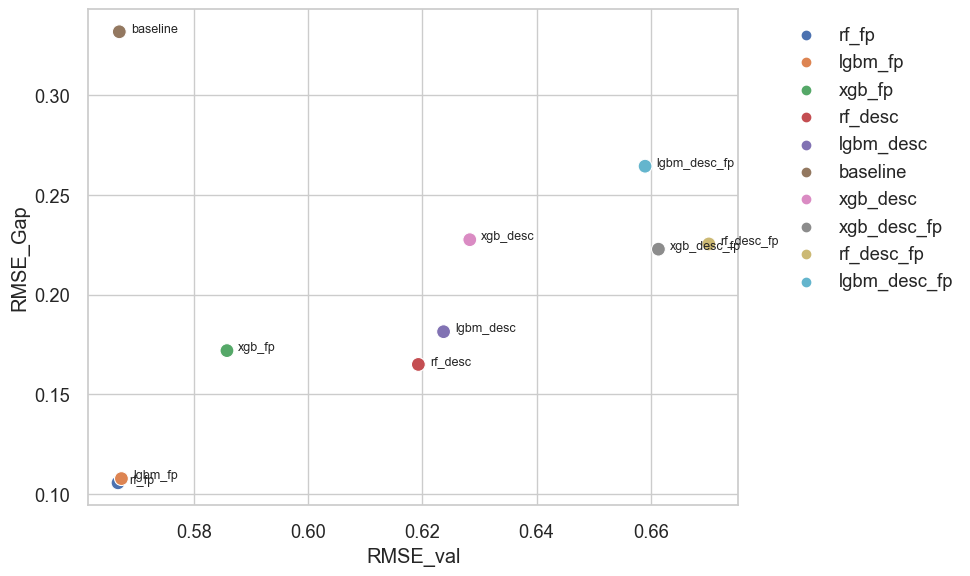

In [ ]:
# Plot
plt.figure(figsize=fig_size)
ax = sns.scatterplot(data=pivot_train_val_melt.sort_values('Distance'), x='RMSE_val', y='RMSE_Gap', hue='Model', s=100)

for i in range(pivot_train_val_melt.shape[0]):
    row = pivot_train_val_melt.iloc[i]
    ax.text(row['RMSE_val'] + 0.002, row['RMSE_Gap'], row['Model'], fontsize=9)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.xlabel('RMSE_val')
plt.ylabel('RMSE_Gap')
plt.show()


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'rf_fp'),
  Text(1, 0, 'lgbm_fp'),
  Text(2, 0, 'xgb_fp'),
  Text(3, 0, 'rf_desc'),
  Text(4, 0, 'lgbm_desc'),
  Text(5, 0, 'baseline'),
  Text(6, 0, 'xgb_desc'),
  Text(7, 0, 'xgb_desc_fp'),
  Text(8, 0, 'rf_desc_fp'),
  Text(9, 0, 'lgbm_desc_fp')])

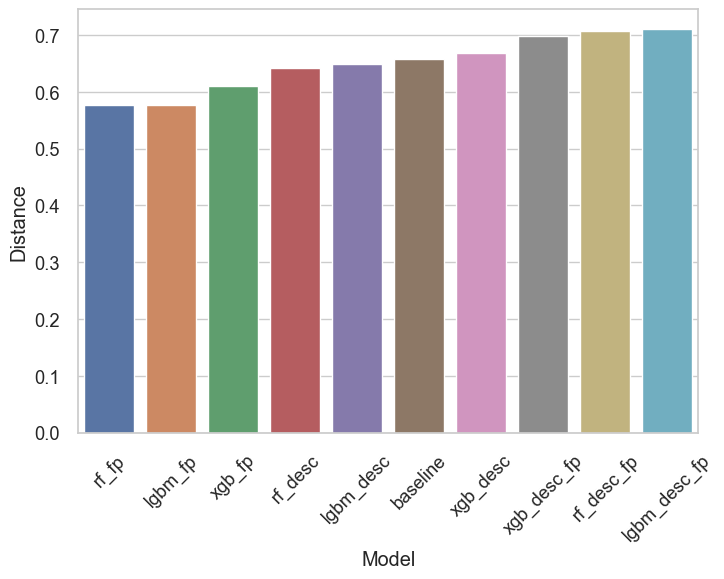

In [ ]:
sns.barplot(data=pivot_train_val_melt.sort_values('Distance'),x='Model',y='Distance')
plt.xticks(rotation=45)

## Visual Predictive Check

In [ ]:
# Generate prediction
model = regressors_dict.get('rf_fp')
model.fit(X_prop_train,y_prop_train)
y_test_pred = model.predict(X_test)

# Diagnostic Plot
sns.scatterplot(y=y_test_pred, x=y_test)
plt.title(key.upper())
plt.xlabel('Normalised pKi')
plt.ylabel('Predicted Normalised pKi')
lims = [min(min(y_test)-1, min(y_test_pred)-1), max(max(y_test)+1, max(y_test_pred)+1)]
plt.plot(lims, lims, 'k--', alpha=0.7,color='red')  # dashed black line
plt.xlim(lims)
plt.ylim(lims)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Residual')

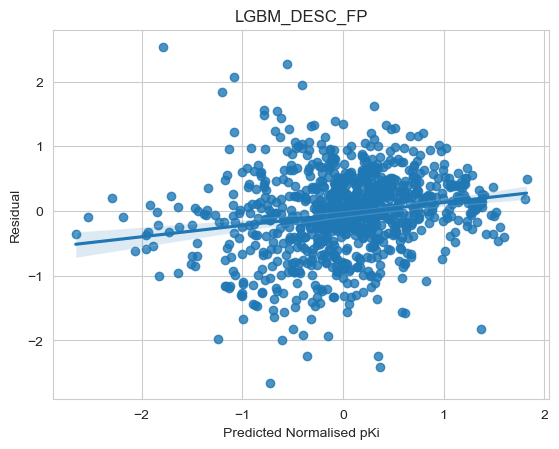

In [ ]:
# Residual Plot
sns.regplot(x=y_test_pred, y=y_test-y_test_pred)
plt.title(key.upper())
plt.xlabel('Predicted Normalised pKi')
plt.ylabel('Residual')

# **5. Classification Models**

# Split data

In [84]:
class_target = df_total['class'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(df_total, class_target, random_state=2406, test_size=0.2,stratify=class_target)
X_prop_train, X_calibrate, y_prop_train, y_calibrate = train_test_split(X_train, y_train, random_state=2406, test_size=0.2,stratify=y_train)

prop_train_index = X_prop_train.index
calibrate_index = X_calibrate.index
test_index =  X_test.index

# Extract descriptors
X_prop_train = desc_fp[prop_train_index]
X_calibrate = desc_fp[calibrate_index]
X_test = desc_fp[test_index]

# Hyperparameter tunnining

In [ ]:
result = optimize_xgb_classifier(X_prop_train,y_prop_train,X_test,y_test,n_calls=50)

## Model comparision

In [85]:
classifier_dict = {'rf_desc': RandomForestClassifier(n_estimators=290,max_depth=19,min_samples_split=11,min_samples_leaf=1,max_features=0.10197393510776986,random_state=42),
               'xgb_desc': xgb.XGBClassifier(n_estimators=181,max_depth=10,learning_rate=0.1914706373874513, subsample=0.9644924666875524,colsample_bytree=0.6,reg_alpha=0,reg_lambda=10,use_label_encoder=False,eval_metric='logloss',random_state=42,n_jobs=-1),
               'lgbm_desc': LGBMClassifier(n_estimators=370,max_depth=15,num_leaves=73,min_child_samples=50,learning_rate=0.018273395828246147,subsample=0.5,colsample_bytree=1.0,random_state=42,n_jobs=-1),
               'rf_fp': RandomForestClassifier(n_estimators=300,max_depth=19,min_samples_split=2,min_samples_leaf=1,max_features=0.1,random_state=42,n_jobs=-1),
               'xgb_fp': xgb.XGBClassifier(n_estimators=300,max_depth=9,learning_rate=0.16981619826788233, subsample=0.6,colsample_bytree=0.795502607486939,reg_alpha=0,reg_lambda=10,use_label_encoder=False,eval_metric='logloss',random_state=42,n_jobs=-1),
               'lgbm_fp': LGBMClassifier(n_estimators=500,max_depth=15,num_leaves=100,min_child_samples=5,learning_rate=0.3,subsample=1.0,colsample_bytree=0.5,random_state=42,n_jobs=-1),
               'rf_desc_fp': RandomForestClassifier(n_estimators=115,max_depth=17,min_samples_split=2,min_samples_leaf=1,max_features=0.10279425455079566,random_state=42,n_jobs=-1),
               'xgb_desc_fp': xgb.XGBClassifier(n_estimators=291,max_depth=9,learning_rate=0.29528072285943874, subsample=0.8489545436917106,colsample_bytree=0.6264182155850841,reg_alpha=5.415836932319522,reg_lambda=3.9666870546339887,use_label_encoder=False,eval_metric='logloss',random_state=42,n_jobs=-1),
               'lgbm_desc_fp': LGBMClassifier(n_estimators=428,max_depth=15,num_leaves=70,min_child_samples=5,learning_rate=0.011584729061888429,subsample=0.5,colsample_bytree=0.5,random_state=42,n_jobs=-1),
               'baseline': RandomForestClassifier()}

In [ ]:
CV_train_result = {}
CV_val_result = {}
CV_test_result = {}

for key in classifier_dict.keys():
    if key == 'svm_desc':
        X_prop_train = decomposed_descriptors[prop_train_index]
        X_calibrate = decomposed_descriptors[calibrate_index]
        X_test = decomposed_descriptors[test_index]

    elif key in ['rf_desc','xgb_desc','lgbm_desc']:
        X_prop_train = scaled_descriptors[prop_train_index]
        X_calibrate = scaled_descriptors[calibrate_index]
        X_test = scaled_descriptors[test_index]

    elif key == 'svm_fp':
        X_prop_train = decomposed_fp[prop_train_index]
        X_calibrate = decomposed_fp[calibrate_index]
        X_test = decomposed_fp[test_index]

    elif key in ['rf_fp','xgb_fp','lgbm_fp','baseline']:
        X_prop_train = morgan_fp[prop_train_index]
        X_calibrate = morgan_fp[calibrate_index]
        X_test = morgan_fp[test_index]
  
    elif key == 'svm_desc_fp':
        X_prop_train = decomposed_desc_fp[prop_train_index]
        X_calibrate = decomposed_desc_fp[calibrate_index]
        X_test = decomposed_desc_fp[test_index]
    
    elif key in ['rf_desc_fp','xgb_desc_fp','lgbm_desc_fp']:
        X_prop_train = desc_fp[prop_train_index]
        X_calibrate = desc_fp[calibrate_index]
        X_test = desc_fp[test_index]

    print(f'Model {key}')
    model = classifier_dict.get(key)
    train_scores, val_scores, test_score = cross_validation_classifier(model, X_prop_train, y_prop_train, X_test, y_test)
    CV_train_result[key] = train_scores
    CV_val_result[key] = val_scores
    CV_test_result[key] = test_score

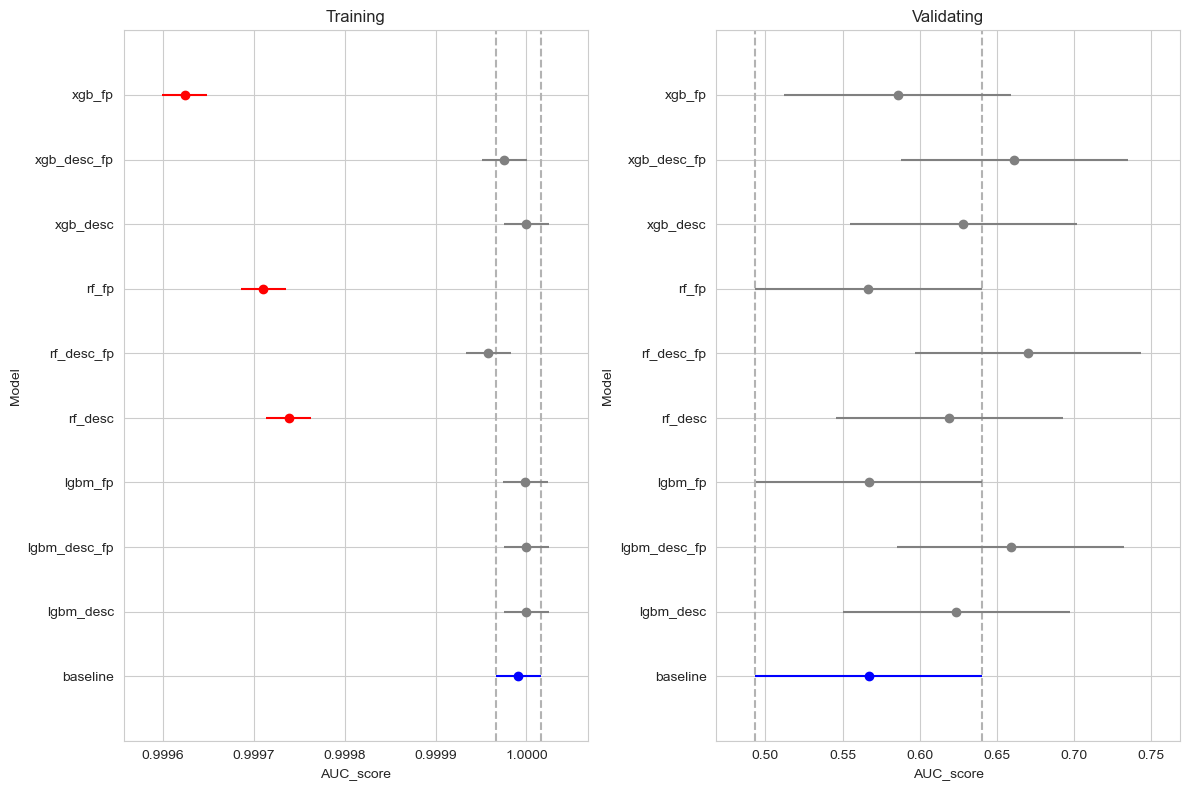

In [ ]:
CV_train_df = pd.DataFrame(CV_train_result)
CV_val_df = pd.DataFrame(CV_val_result)
df_train_melt = CV_train_df.melt(var_name='Model',value_name='AUC_score')
df_val_melt = CV_val_df.melt(var_name='Model',value_name='AUC_score')

# Run tukeyhsd test
tukey_val = pairwise_tukeyhsd(endog=df_val_melt['AUC_score'], groups=df_val_melt["Model"], alpha=0.05)
tukey_train = pairwise_tukeyhsd(endog=df_train_melt['AUC_score'], groups=df_train_melt["Model"], alpha=0.05)

# Plot result and CI
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 20))
tukey_train.plot_simultaneous('baseline', figsize=(12, 8), xlabel='AUC_score', ylabel='Model', ax=axes[0])
tukey_val.plot_simultaneous('baseline', figsize=(12, 8), xlabel='AUC_score', ylabel='Model', ax=axes[1])
for ax, title in zip(axes,['Training','Validating','Testing']):
    ax.grid(True)
    ax.set_title(title)

plt.tight_layout()
plt.show()

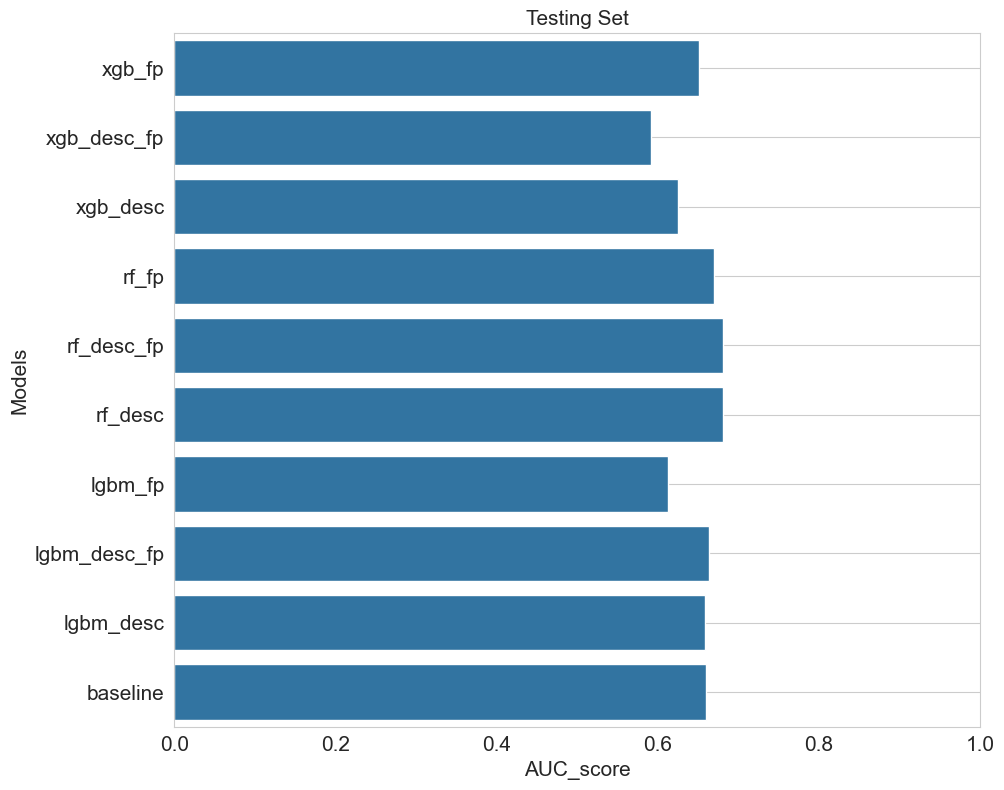

In [ ]:
# Testing set result
df = pd.DataFrame(list(CV_test_result.items()), columns=['Model', 'Performance'])
df = df.sort_values('Model', ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(y='Model', x='Performance', data=df, color='#1f77b4')
plt.ylabel('Models',fontsize=15)
plt.xlabel('AUC_score',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Testing Set',fontsize=15)
plt.tight_layout()
plt.grid()
plt.xlim(0,1)
plt.show()

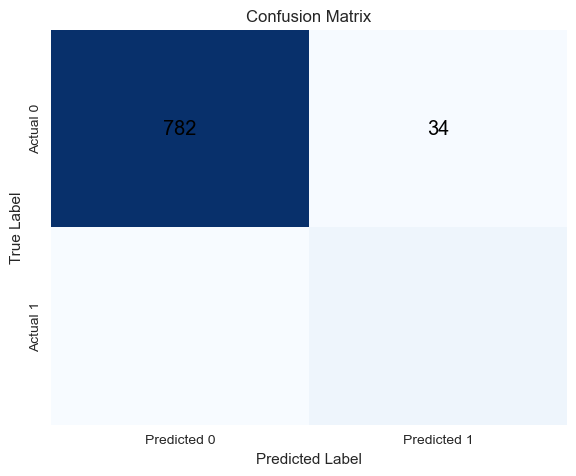

Classification Report:
              precision    recall  f1-score   support

           0      0.964     0.958     0.961       816
           1      0.646     0.681     0.663        91

    accuracy                          0.931       907
   macro avg      0.805     0.820     0.812       907
weighted avg      0.932     0.931     0.931       907



In [ ]:
model = classifier_dict.get('rf_desc_fp')
model.fit(X_prop_train,y_prop_train)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Convert probabilities to class labels
threshold = 0.33
y_pred = (y_pred_proba >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"color": "black"},
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))


/Users/lod/miniconda3/envs/MLcode/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lod/miniconda3/envs/MLcode/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Precision')

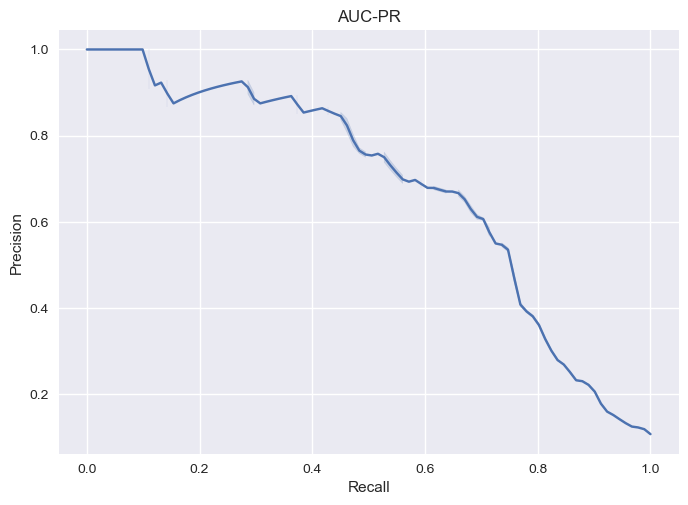

In [ ]:
# Precision - Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
auc_pr = auc(recall, precision)

sns.lineplot(y=precision,x=recall)
plt.title('AUC-PR')
plt.xlabel('Recall')
plt.ylabel('Precision')

In [30]:
result = {'thresholds': np.concatenate([np.array([0]),thresholds]), 'Recall': recall, "Precision": precision}
result = pd.DataFrame(result)
result['Distance'] = np.sqrt((1-result['Recall'].to_numpy())**2+(1-result['Precision'].to_numpy())**2)
result = result.sort_values('Distance')
optimal_theshold = result.iloc[0].thresholds
optimal_recall = result.iloc[0].Recall
optimal_precision = result.iloc[0].Precision

print(f'Optimal Threshold: {optimal_theshold}')
print(f'Optimal Recall: {optimal_recall}')
print(f'Optimal Precision: {optimal_precision}')

Optimal Threshold: 0.3311230828024688
Optimal Recall: 0.6703296703296703
Optimal Precision: 0.6630434782608695


# **6.Conformal Prediction**

## Regression model

In [ ]:
# Initialize Inductive Conformal Regressor
regressor = regressors_dict.get('xgb_fp') 
nc_reg = NcFactory.create_nc(regressor) 
icp_reg = IcpRegressor(nc_reg)

# Train underlying model and set calibration examples
icp_reg.fit(X_prop_train,y_prop_train)
icp_reg.calibrate(X_calibrate,y_calibrate)

# Predict
sign_vals = np.arange(0.01,1,0.01)
many_intervals = icp_reg.predict(X_test)
many_intervals.shape

(907, 2, 99)

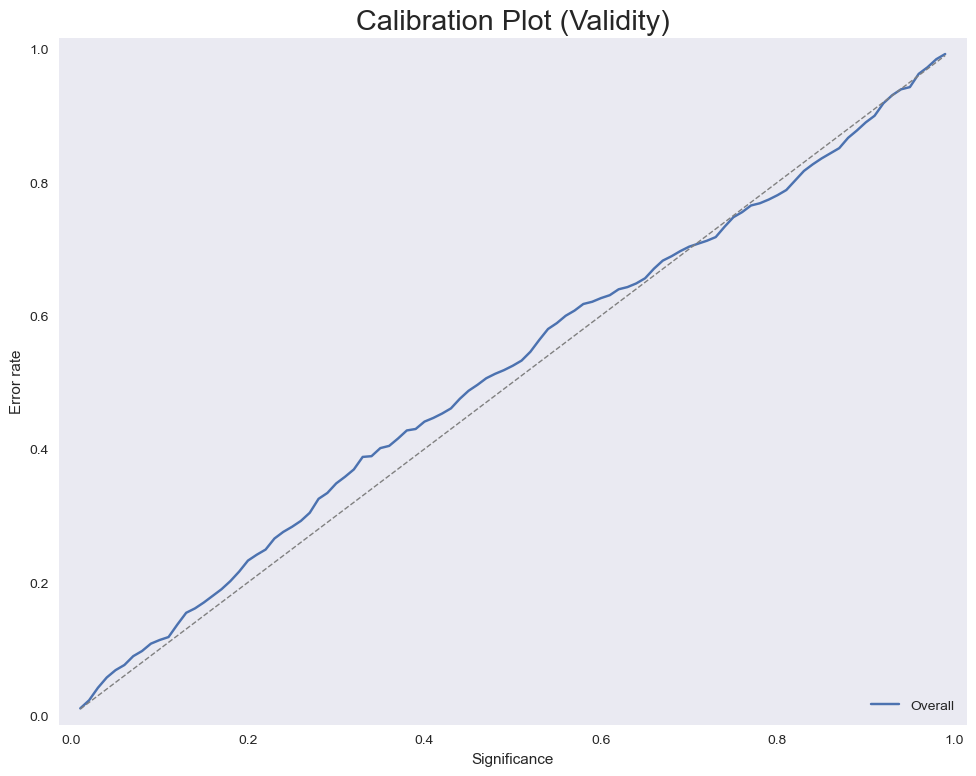

In [ ]:
# Calibration plot
icp_calib_fig = plotting.plot_calibration(sign_vals=sign_vals,
                                          error_rates=metrics.frac_error_reg(y_test,many_intervals),title='Calibration Plot (Validity)')
plt.grid()

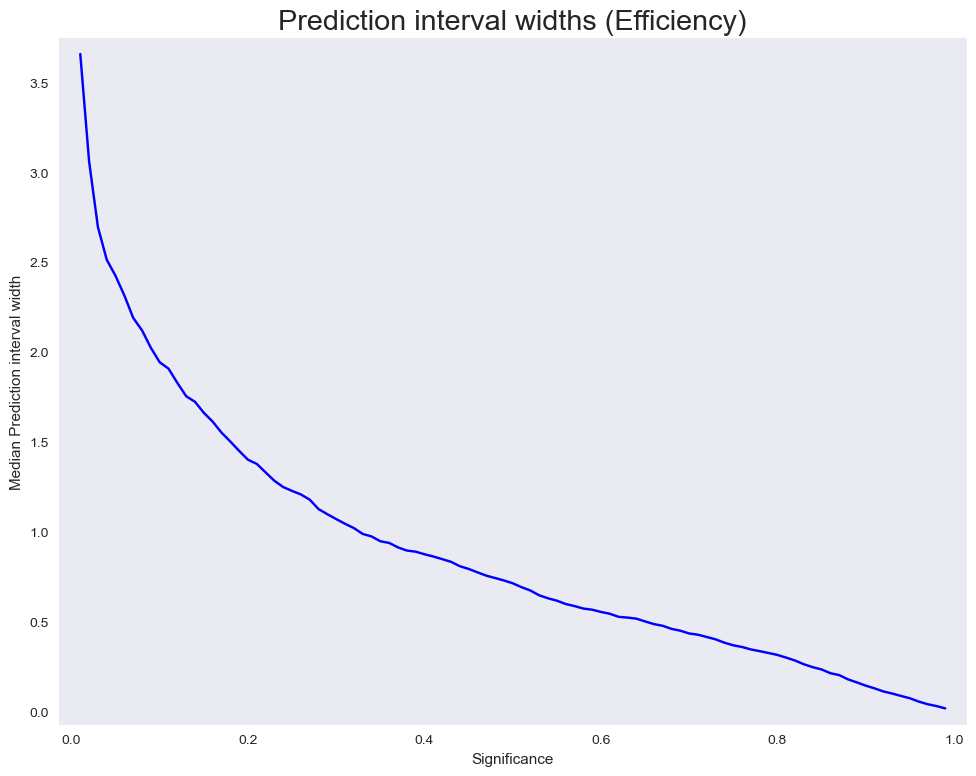

In [ ]:
# Efficiency plot
icp_eff_fig = plotting.plot_pred_widths(sign_vals=sign_vals,
                                        pred_widths=metrics.pred_width(many_intervals),
                                        title="Prediction interval widths (Efficiency)")
plt.grid()

In [54]:
int_width = metrics.pred_width(many_intervals)
norm_int_width = (int_width - int_width.min())/(int_width.max()-int_width.min())
efficiency = {'norm_int_width': norm_int_width, 'significance': sign_vals}
efficiency = pd.DataFrame(efficiency)
efficiency['Distance'] = np.sqrt(np.array(efficiency['norm_int_width'])**2+np.array(efficiency['significance'])**2)
efficiency = efficiency.sort_values('Distance')
optimal_significance = efficiency.sort_values('Distance').iloc[0].significance
optimal_norm_int_width = efficiency.sort_values('Distance').iloc[0].norm_int_width

print(f'Optimal significance: {optimal_significance}')
print(f'Median Prediction Interval Width: {optimal_norm_int_width*((int_width.max()-int_width.min()))+int_width.min()}')

Optimal significance: 0.28
Median Prediction Interval Width: 1.1256452705821856


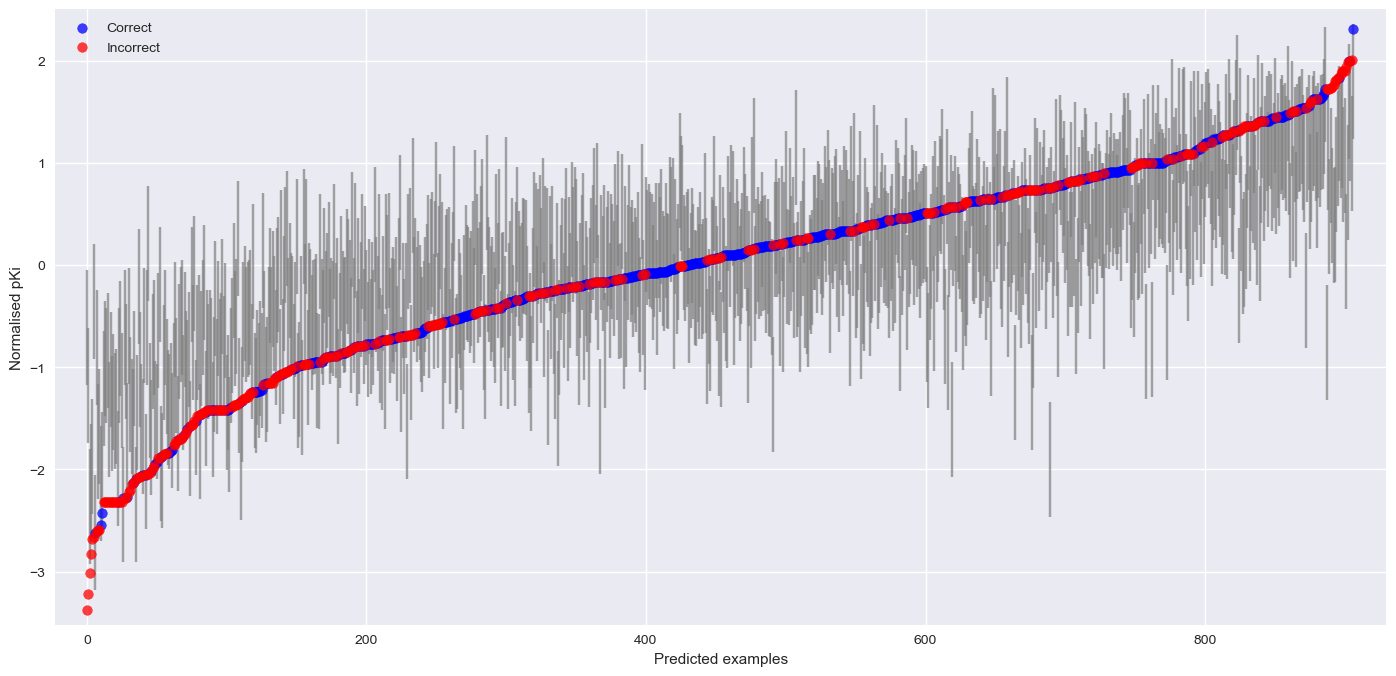

In [ ]:
# Visual Predictive check
intervals_fig = plotting.plot_pred_intervals(y_test,
                                             many_intervals[:,:,np.where(sign_vals==optimal_significance)[0]].squeeze(),
                                             figsize = fig_size)
plt.ylabel('Normalised pKi')
plt.legend()

## Classification Model

In [86]:
# Initialize Inducitve Conformal classifier
clf = classifier_dict.get('rf_desc_fp') 
nc = NcFactory.create_nc(clf) 
icp = IcpClassifier(nc, condition=lambda x: x[1]) 

# Train the ICP
icp.fit(X_prop_train, y_prop_train) 
icp.calibrate(X_calibrate,y_calibrate)

# Predict labels
np.random.seed(2406)
predictions = icp.predict(X_test, significance=.05)

# Get raw p_values
np.random.seed(2406)
pvalues = icp.predict(X_test) 

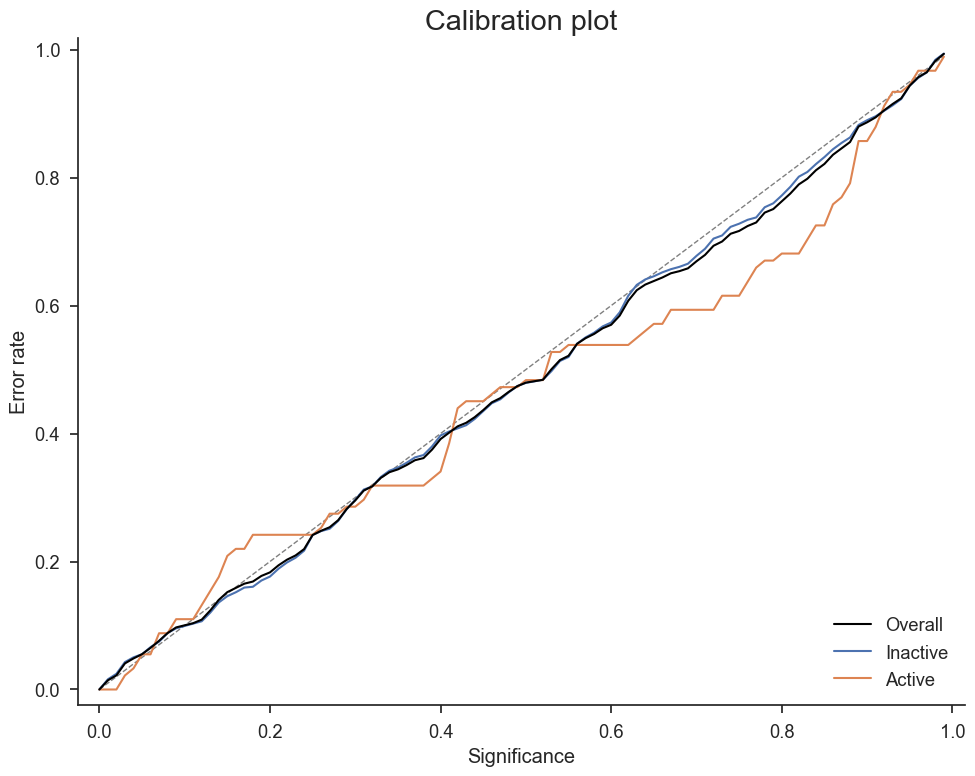

In [87]:
# Calibration plot
calib_fig = plotting.plot_calibration_clf(y_test, 
                                            pvalues, 
                                            title='Calibration plot',
                                            labels=['Inactive','Active'],
                                            figsize=None)

Text(0.5, 1.0, 'Efficiency plot')

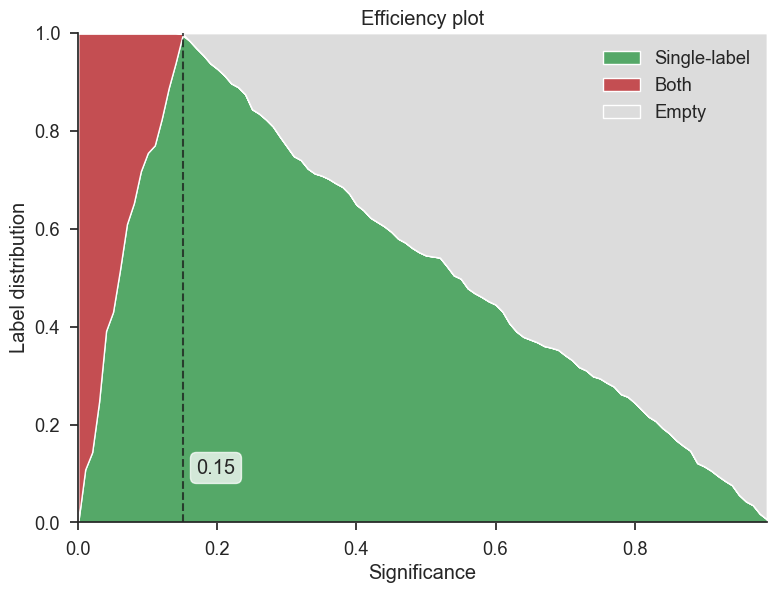

In [88]:
# Efficiency plot
label_distr_fig = plotting.plot_label_distribution(y_true=y_test,
                                                   p_values=pvalues,
                                                   sign_vals=np.arange(0,1,0.01),
                                                   mark_best=True,
                                                   display_incorrect=False,
                                                   figsize = (8,6))
plt.title('Efficiency plot')

Confusion matrix using significance 0.15


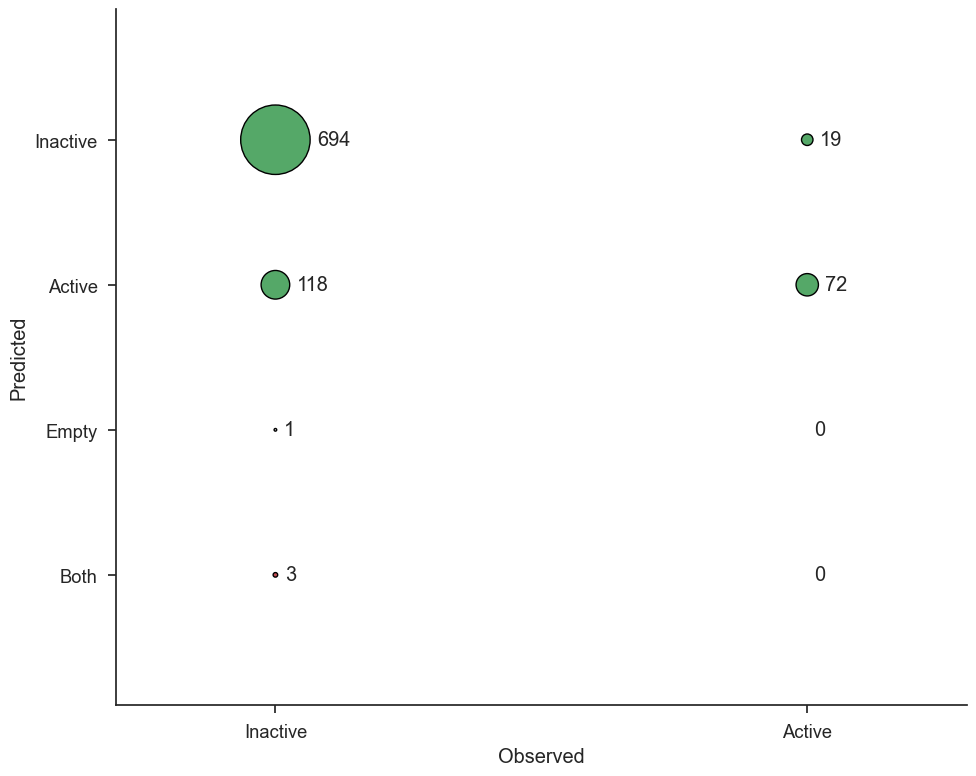

In [89]:
# Confusion matrix
significance_level = 0.15
CM = metrics.confusion_matrix(y_test, pvalues, sign=significance_level, labels=['Inactive','Active'])
print(f'Confusion matrix using significance {significance_level}')

CM_plot = plotting.plot_confusion_matrix_bubbles(CM,
                                                annotate=True) # If numbers should be printed next to bubbles

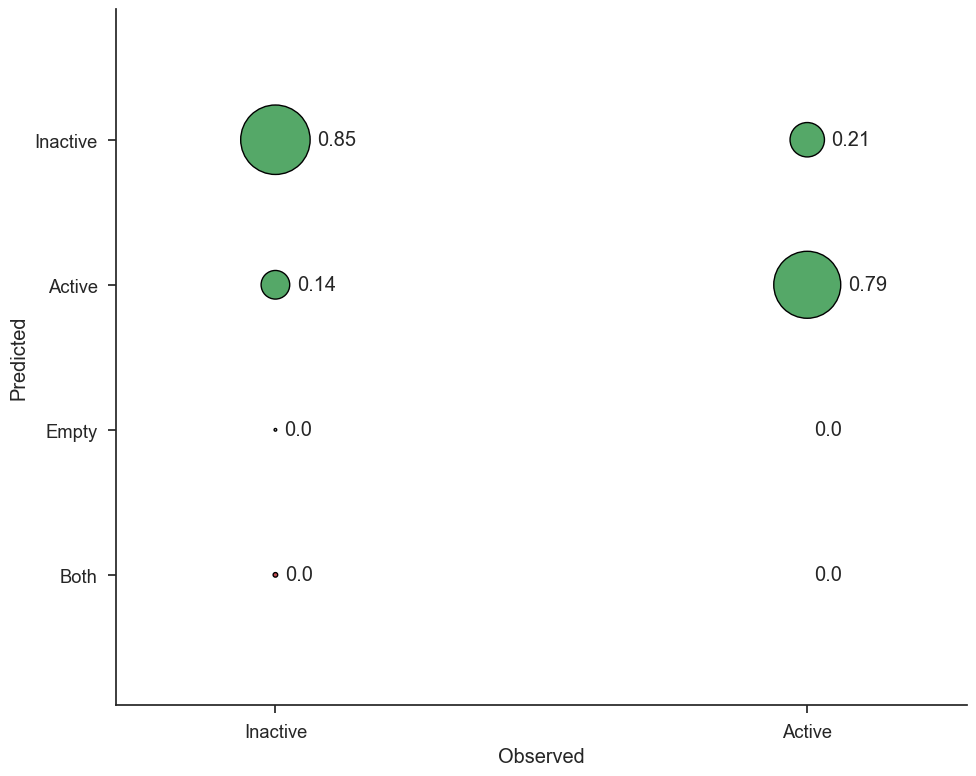

In [90]:
CM_norm = metrics.confusion_matrix(y_test, 
                                   pvalues, 
                                   sign=significance_level, 
                                   labels=['Inactive','Active'], 
                                   normalize_per_class=True)

bubbles_normalized_plot = plotting.plot_confusion_matrix_bubbles(CM_norm,
                                                                 annotate=True)